In [1]:
import pandas as pd
import numpy as np


def load_tweets():
    return pd.read_csv('customer-support-on-twitter/twcs.zip', index_col=0)


tweets = load_tweets()

/opt/devhome/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
tweets.head(1202).tail(6)

,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
tweet_id,,,,,,
1786,AppleSupport,False,Tue Oct 31 22:30:01 +0000 2017,@116107 Glad to hear and just reach out again ...,NaN,1787.0
1787,116107,True,Tue Oct 31 22:10:27 +0000 2017,@AppleSupport Worked 👌🏽,1786,1788.0
1788,AppleSupport,False,Tue Oct 31 21:46:54 +0000 2017,@116107 Please keep us posted afterwards.,1787,1789.0
1789,116107,True,Tue Oct 31 21:32:24 +0000 2017,@AppleSupport No I had 11.0.3 but now it says ...,1788,1790.0
1790,AppleSupport,False,Tue Oct 31 21:30:00 +0000 2017,@116107 Apps are important and we want you to ...,1789,1791.0
1791,116107,True,Tue Oct 31 21:25:20 +0000 2017,why won’t my apps fuccin download or update @A...,1790,NaN


In [3]:
tweets.loc[tweets['inbound']==False]['author_id'].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps', 'ATVIAssist',
       'AdobeCare', 'AmazonHelp', 'XboxSupport', 'AirbnbHelp',
       'nationalrailenq', 'AirAsiaSupport', 'Morrisons', 'NikeSupport',
       'AskAmex', 'McDonalds', 'YahooCare', 'AskLyft', 'UPSHelp', 'Delta',
       'AppleSupport', 'Uber_Support', 'Tesco', 'SpotifyCares',
       'British_Airways', 'comcastcares', 'AmericanAir', 'TMobileHelp',
       'VirginTrains', 'SouthwestAir', 'AskeBay', 'hulu_support',
       'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport', 'ChaseSupport',
       'CoxHelp', 'DropboxSupport', 'VirginAtlantic', 'BofA_Help',
       'AzureSupport', 'AlaskaAir', 'ArgosHelpers', 'Postmates_Help',
       'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp', 'AskPapaJohns',
       'SW_Help', 'askpanera', 'Walmart', 'USCellularCares',
       'AsurionCares', 'GloCare', 'idea_cares', 'DoorDash_Help',
       'NeweggService', 'VirginA

In [2]:
# Pick only inbound tweets that aren't in reply to anything...
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]
print('Found {} first inbound messages.'.format(len(first_inbound)))

# Merge in all tweets in response
#inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
#                                  right_on='in_response_to_tweet_id')
#print("Found {} responses.".format(len(inbounds_and_outbounds)))

inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_index=True, 
                                  right_on='in_response_to_tweet_id')


# Filter out cases where reply tweet isn't from company
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]
inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='Walmart']

Found 787346 first inbound messages.


,in_response_to_tweet_id,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
tweet_id,,,,,,,,,,,,,
2378,2380,116254,True,Tue Oct 31 21:53:32 +0000 2017,Just got recognized at @Walmart as the guy who...,2378,NaN,Walmart,False,Tue Oct 31 22:39:02 +0000 2017,"@116254 We disagree, Dylan. We're excited that...",2379,2380
2383,2384,116256,True,Sun Oct 29 05:03:21 +0000 2017,we all know walmart is better in terms of a lo...,2383,NaN,Walmart,False,Sun Oct 29 14:16:20 +0000 2017,"@116256 We ❤️ you too, Angel. Thanks for havin...",2382,2384
2390,2391,116259,True,Tue Oct 31 19:01:20 +0000 2017,It isn’t every day you get 3 carts full of bla...,2390,NaN,Walmart,False,Tue Oct 31 22:08:18 +0000 2017,@116259 We love it! Sounds like a double win! ...,NaN,2391
2392,2393,116260,True,Tue Oct 31 20:34:57 +0000 2017,Used @Walmart #grocerypickup and it's a pretty...,2392,NaN,Walmart,False,Tue Oct 31 22:00:57 +0000 2017,@116260 Yay! We're thrilled to hear you've enj...,NaN,2393
2394,2395,116261,True,Tue Oct 31 20:45:49 +0000 2017,Everybody I’ve met at Walmart is so friendly! ...,2394,NaN,Walmart,False,Tue Oct 31 21:53:49 +0000 2017,@116261 We want you to leave our store with a ...,NaN,2395
2398,2399,116262,True,Tue Oct 31 17:10:30 +0000 2017,Happy Halloween! Look at these pumpkins that w...,2398,NaN,Walmart,False,Tue Oct 31 17:34:28 +0000 2017,@116262 Nothing but the best for the communiti...,2397,2399
2400,2401,116263,True,Tue Oct 31 20:49:09 +0000 2017,"Shout to the @Walmart in Thomaston GA, for act...",2400,NaN,Walmart,False,Tue Oct 31 21:45:31 +0000 2017,"@116263 Woot Woot! Thanks for the shout out, W...",NaN,2401
7965,7966,117369,True,Tue Oct 31 20:46:28 +0000 2017,Just your friendly neighborhood assassin havin...,7965,NaN,Walmart,False,Tue Oct 31 22:49:58 +0000 2017,"@117369 We're not judging, Teresa. You have to...",NaN,7966
12906,12907,118616,True,Wed Nov 01 00:16:12 +0000 2017,I saw this in Walmart and picked it up right a...,12906,NaN,Walmart,False,Wed Nov 01 01:42:13 +0000 2017,"@118616 A truly wonderful young woman, indeed....",NaN,12907


In [3]:
sorted_answerers=inbounds_and_outbounds.groupby('author_id_y').size().sort_values()
sorted_answerers_sum = sorted_answerers.values.sum()
sorted_answerers_sum_percent=sorted_answerers/sorted_answerers_sum*100.0

In [4]:
sorted_answerers_sum_percent[-20:]

author_id_y
sainsburys          1.355031
AskPlayStation      1.434850
XboxSupport         1.574848
sprintcare          1.592473
ChipotleTweets      1.744054
hulu_support        1.786984
UPSHelp             1.799448
VirginTrains        1.807506
Ask_Spectrum        2.174244
British_Airways     2.468969
TMobileHelp         2.526127
SouthwestAir        2.642078
comcastcares        3.001515
AmericanAir         3.085236
Tesco               3.133203
SpotifyCares        3.391670
Delta               3.586181
Uber_Support        5.039538
AppleSupport        9.395958
AmazonHelp         10.655559
dtype: float64

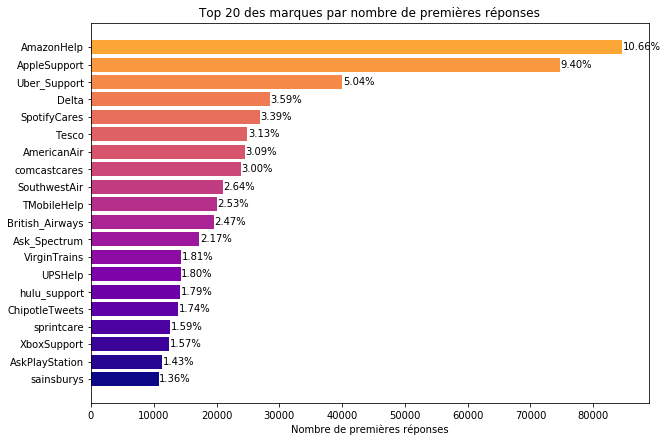

In [5]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
pos=np.arange(20)+0.5
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
colors = cm.plasma_r(np.linspace(1,.2, 20))
plt.barh(pos,sorted_answerers.values[-20:],color=colors, tick_label=sorted_answerers.keys()[-20:])
plt.yticks(pos,sorted_answerers.keys()[-20:])
plt.xlabel('Nombre de premières réponses')
plt.title('Top 20 des marques par nombre de premières réponses')
for i, v in enumerate(sorted_answerers.values[-20:]):
    ax.text(v + 100, i + .35, "{:.2f}%".format(sorted_answerers_sum_percent[-20:][i]))

plt.show()

In [5]:
def all_tweets_to(tweets, author_id):
    return tweets.loc[pd.unique(tweets.loc[(tweets['inbound']==False) & (tweets['author_id'] == author_id)]['in_response_to_tweet_id'])]

def all_initial_tweets_to(tweets, author_id):
    return tweets[(tweets.text.str.contains(author_id)) & (tweets.in_response_to_tweet_id.isnull())]

In [6]:
#all_initial_tweets_to(tweets,'@OfficeSupport')
inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='Walmart']

,in_response_to_tweet_id,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
tweet_id,,,,,,,,,,,,,
2378,2380,116254,True,Tue Oct 31 21:53:32 +0000 2017,Just got recognized at @Walmart as the guy who...,2378,NaN,Walmart,False,Tue Oct 31 22:39:02 +0000 2017,"@116254 We disagree, Dylan. We're excited that...",2379,2380
2383,2384,116256,True,Sun Oct 29 05:03:21 +0000 2017,we all know walmart is better in terms of a lo...,2383,NaN,Walmart,False,Sun Oct 29 14:16:20 +0000 2017,"@116256 We ❤️ you too, Angel. Thanks for havin...",2382,2384
2390,2391,116259,True,Tue Oct 31 19:01:20 +0000 2017,It isn’t every day you get 3 carts full of bla...,2390,NaN,Walmart,False,Tue Oct 31 22:08:18 +0000 2017,@116259 We love it! Sounds like a double win! ...,NaN,2391
2392,2393,116260,True,Tue Oct 31 20:34:57 +0000 2017,Used @Walmart #grocerypickup and it's a pretty...,2392,NaN,Walmart,False,Tue Oct 31 22:00:57 +0000 2017,@116260 Yay! We're thrilled to hear you've enj...,NaN,2393
2394,2395,116261,True,Tue Oct 31 20:45:49 +0000 2017,Everybody I’ve met at Walmart is so friendly! ...,2394,NaN,Walmart,False,Tue Oct 31 21:53:49 +0000 2017,@116261 We want you to leave our store with a ...,NaN,2395
2398,2399,116262,True,Tue Oct 31 17:10:30 +0000 2017,Happy Halloween! Look at these pumpkins that w...,2398,NaN,Walmart,False,Tue Oct 31 17:34:28 +0000 2017,@116262 Nothing but the best for the communiti...,2397,2399
2400,2401,116263,True,Tue Oct 31 20:49:09 +0000 2017,"Shout to the @Walmart in Thomaston GA, for act...",2400,NaN,Walmart,False,Tue Oct 31 21:45:31 +0000 2017,"@116263 Woot Woot! Thanks for the shout out, W...",NaN,2401
7965,7966,117369,True,Tue Oct 31 20:46:28 +0000 2017,Just your friendly neighborhood assassin havin...,7965,NaN,Walmart,False,Tue Oct 31 22:49:58 +0000 2017,"@117369 We're not judging, Teresa. You have to...",NaN,7966
12906,12907,118616,True,Wed Nov 01 00:16:12 +0000 2017,I saw this in Walmart and picked it up right a...,12906,NaN,Walmart,False,Wed Nov 01 01:42:13 +0000 2017,"@118616 A truly wonderful young woman, indeed....",NaN,12907


In [110]:
#tutu = all_tweets_to(tweets,'@Walmart')
#tweets[(tweets.text.str.contains('@Walmart')) & (tweets.in_response_to_tweet_id.isnull())].text.count()
# apple = tweets[(tweets.text.str.contains('@AppleSupport')) & (tweets.in_response_to_tweet_id.isnull())].text
#apple = all_initial_tweets_to(tweets, '@AppleSupport')

#print(apple.loc[765].text)
#print(apple.loc[733].text)
#print(apple.loc[2987723].text)

    

In [10]:
apple = inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='AppleSupport']
print(apple.iloc[2].text_x)
print(apple.iloc[3].text_x)
print(apple.iloc[5].text_x)

@115858 @AppleSupport hello are all the lines closed for tonight #help
Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7
Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤


In [9]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re 

tknzr = TweetTokenizer(preserve_case=False)

def preprocess_tweet(tweet):
    import string
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '<url>', tweet)  # URLs
    tweet = re.sub(r'(?:@[\d]+)', '<user>', tweet)  # numeric user-mentions
    #tweet = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', '<hashtag>', tweet)  # hashtags
    #tweet = re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)', '<number>', tweet)  # numbers
    
   # translate_table = dict((ord(char), None) for char in string.punctuation)   
    
    #return tweet.translate(translate_table)
    return tweet

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000,stop_words='english', tokenizer=None, preprocessor=preprocess_tweet)
X = vectorizer.fit_transform(apple.text)
print("n_samples: %d, n_features: %d" % X.shape)

AttributeError: 'DataFrame' object has no attribute 'text'

In [125]:
# 2 3 ou 5
test_text = apple.iloc[3].text_x
print(test_text)
print(tknzr.tokenize(test_text))

token_pattern = re.compile(r"(?u)\b\w\w+\b")
print(token_pattern.findall(test_text))

url_regex = '(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+)|\b\w+'
#token_pattern = re.compile(r"(?u)"+ url_regex+"|(?:(?:\b\w|\B[@#])\w+\b)")
token_pattern = re.compile(r"(?u)"+ url_regex+"")
print(token_pattern.findall(test_text))

Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7
['hello', ',', 'internet', '.', 'can', 'someone', 'explain', 'why', 'this', 'symbol', 'keeps', 'appearing', 'on', 'my', 'phone', 'and', 'when', 'i', '️', 'try', 'to', 'type', 'the', 'letter', 'i', '️', '?', 'also', '@applesupport', 'https://t.co/QKwvTLtiN7']
['Hello', 'internet', 'Can', 'someone', 'explain', 'why', 'this', 'symbol', 'keeps', 'appearing', 'on', 'my', 'phone', 'and', 'when', 'try', 'to', 'type', 'the', 'letter', 'Also', 'AppleSupport', 'https', 'co', 'QKwvTLtiN7']
['https://t.co/QKwvTLtiN7']


In [7]:
def print_top_words(centroids, feature_names, n_top_words):
    for topic_idx, topic in enumerate(centroids):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Clustering sparse data with MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=2018, reassignment_ratio=0.01, tol=0.0,
        verbose=1)
Init 1/1 with method: k-means++
Inertia for init 1/1: 959.638048
Minibatch iteration 1/10200: mean batch inertia: 0.969613, ewa inertia: 0.969613 
Minibatch iteration 2/10200: mean batch inertia: 0.969630, ewa inertia: 0.969614 
Minibatch iteration 3/10200: mean batch inertia: 0.967214, ewa inertia: 0.969567 
Minibatch iteration 4/10200: mean batch inertia: 0.968444, ewa inertia: 0.969545 
Minibatch iteration 5/10200: mean batch inertia: 0.968328, ewa inertia: 0.969521 
Minibatch iteration 6/10200: mean batch inertia: 0.968314, ewa inertia: 0.969497 
Minibatch iteration 7/10200: mean batch inertia: 0.963799, ewa inertia: 0.969385 
Minibatch iteration 8/10200: mean batch inertia: 0.965496, ewa inertia: 0.969308 
Minibatch iter

done in 0.235s

Topics in K-means model:
Topic #0:
url update just app letter iphone time question Apple type
Topic #1:
phone update new updated My user keeps 11 freezing just
Topic #2:
does Why url phone iPhone mean user What update turn
Topic #3:
user url fix What going 11 iOS update Hey Why
Topic #4:
11 iOS battery update new life ios fix user IOS
Topic #5:
iPhone 11 iOS update battery Plus new My 6s user
Topic #6:
user Apple Music url fix update app new time amp
Topic #7:
won let phone update iPhone turn work url help My
Topic #8:
url fix going letter shit problem bug glitch issue Hey
Topic #9:
help url need Please iPhone Can phone user update Apple



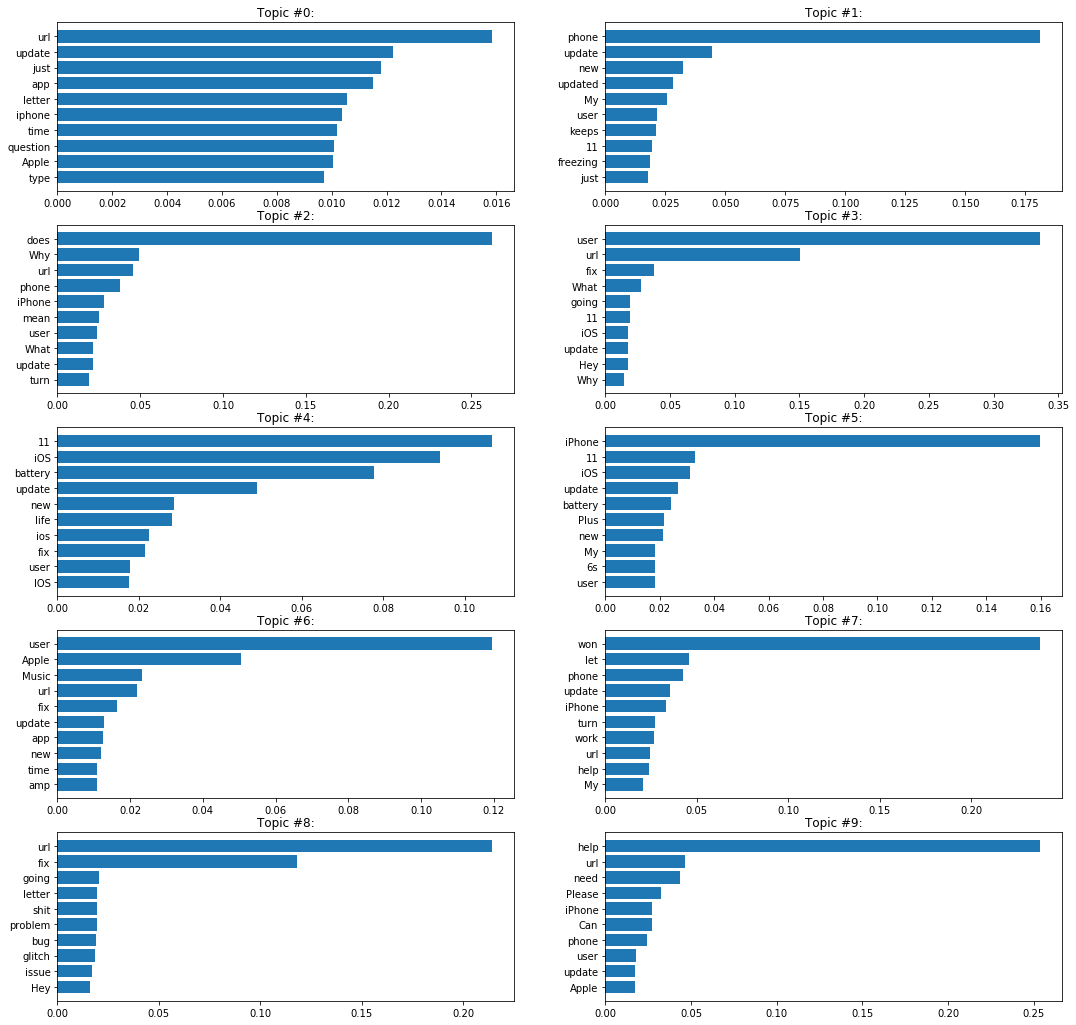

In [59]:
from sklearn.cluster import MiniBatchKMeans
from time import time

# Do the actual clustering with online K-Means
nb_of_topics = 10
km = MiniBatchKMeans(n_clusters=nb_of_topics, init='k-means++', n_init=1,
                     init_size=1000, batch_size=500, verbose=1,  random_state=2018)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

# Look at terms that are the most present in each class
feature_names = vectorizer.get_feature_names()
n_top_words = 10

print("\nTopics in K-means model:")

print_top_words(km.cluster_centers_, feature_names, n_top_words)
#for k, centroid in enumerate(km.cluster_centers_):
#    print("Cluster #%d:" % k)
#    print(" ".join([feature_names[i]
#                    for i in centroid.argsort()[:-n_top_words - 1:-1]]))
print_top_words_histo(km.cluster_centers_, feature_names, n_top_words)


In [12]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=nb_of_topics, random_state=2018,
          alpha=.1, l1_ratio=.5).fit(X)
print_top_words(nmf.components_, feature_names, n_top_words)

Topic #0:
11 iOS updated ios 10 updating IOS bug slow 6s
Topic #1:
url happening What Hey does explain doing bug email like
Topic #2:
user What Fix apple iphone FIX iOS11 THIS ios11 Hey
Topic #3:
fix glitch problem shit issue going need gonna Please bug
Topic #4:
phone updated My keeps freezing does ve calls doing just
Topic #5:
help need Please Can pls hi iphone Hi apple won
Topic #6:
letter question type mark box Why marks boxes time seeing
Topic #7:
iPhone Apple just screen app My work working ve It
Topic #8:
update new latest apps software This The did slow iphone
Topic #9:
battery life draining check health fast drains drain hours iPhone



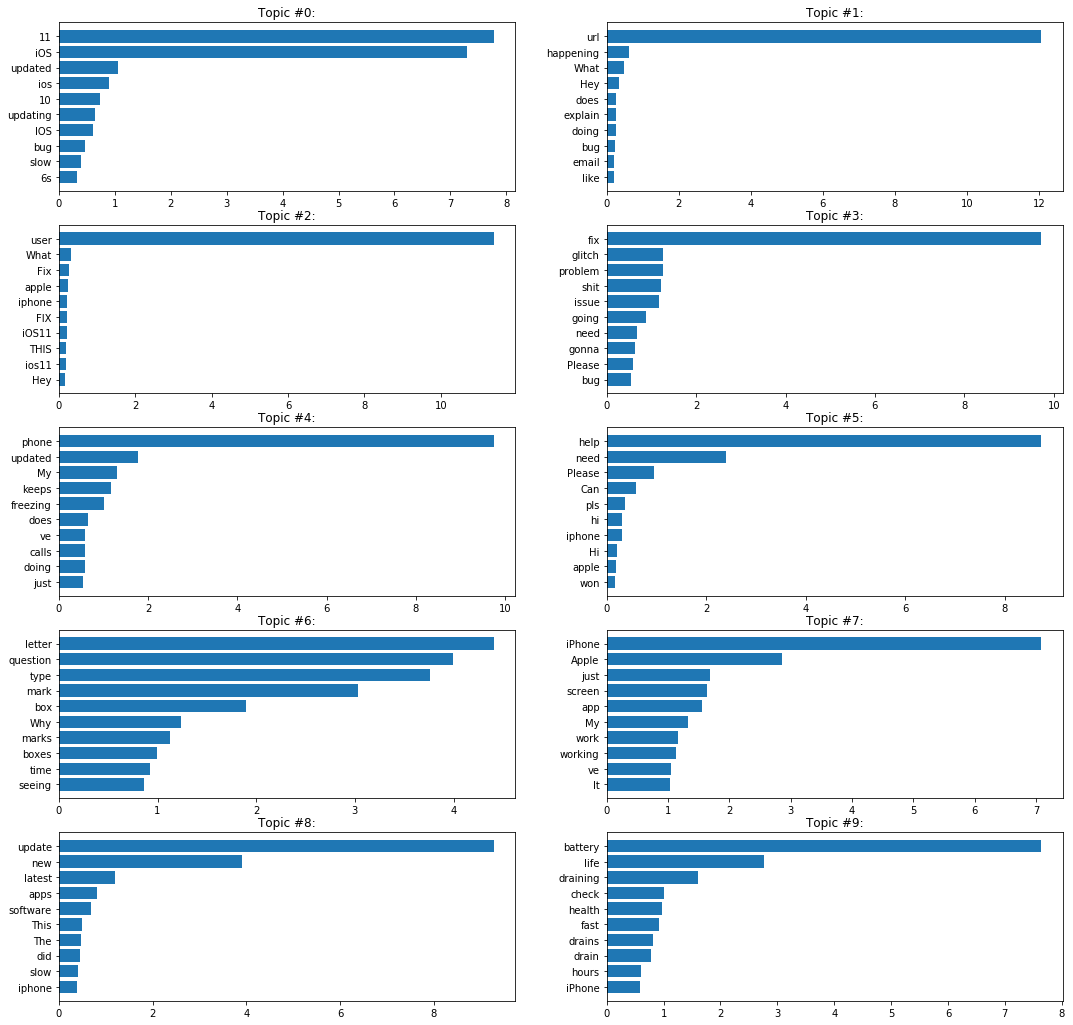

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
def print_top_words_histo(centroids, feature_names, n_top_words):
    plt.figure(figsize=(18,18))
    for topic_idx, topic in enumerate(centroids):
        plt.subplot(centroids.shape[0]/2,2,topic_idx+1)
        plt.title("Topic #%d:" % topic_idx)
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        weights = [topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        plt.barh(range(centroids.shape[0],0,-1),weights, tick_label=words)
    plt.show()
print_top_words_histo(nmf.components_, feature_names, n_top_words)

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=10000,
                                stop_words='english', preprocessor=preprocess_tweet)
X_tf = tf_vectorizer.fit_transform(apple.text)
lda = LatentDirichletAllocation(n_components=nb_of_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=2018)
t0 = time()
lda.fit(X_tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda.components_, tf_feature_names, n_top_words)

done in 40.018s.

Topics in LDA model:
Topic #0:
work doesn 10 apple iPad slow MacBook randomly thing Pro
Topic #1:
having user issues want message error wifi play wtf iPhone
Topic #2:
11 iOS phone update iPhone new screen does apps updated
Topic #3:
way user url MY check THIS THE tired IT iMessage
Topic #4:
url app ve got just don help email trying iCloud
Topic #5:
Apple amp iOS11 Music music upgrade send Mac WiFi iPhone
Topic #6:
battery 11 user update iOS life ios know phone updates
Topic #7:
phone iPhone won new shit My just iTunes hi ID
Topic #8:
fix user url issue working help use phone need Please
Topic #9:
url user Apple type letter question going Is glitch Why

